In [32]:
import pandas as pd
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, roc_auc_score
import statistics
import matplotlib.pyplot as plt

In [2]:
!ls ../titanic/data

TitanicData2.csv         TitanicData2_dcTest.csv  TitanicData2_dcTrain.csv


In [3]:
df_train = pd.read_csv('../titanic/data/TitanicData2_dcTrain.csv')
df_test = pd.read_csv('../titanic/data/TitanicData2_dcTest.csv')
print(df_train.shape, df_test.shape)
df_train.head()

(1047, 8) (262, 8)


,Passenger_Id,pclass,sex,age,sibsp,parch,fare,survived
0,648,3rd,female,22.0,0,0,7.7500,1
1,391,3rd,male,16.0,1,3,34.3750,0
2,351,1st,female,49.0,1,0,76.7292,1
3,1163,3rd,female,24.0,0,0,7.7500,0
4,105,3rd,female,18.0,0,0,9.8417,1


In [4]:
# カテゴリカルカラムをcategory型に変換
df_train['pclass'] = df_train['pclass'].astype('category')
df_train['sex'] = df_train['sex'].astype('category')
df_test['pclass'] = df_test['pclass'].astype('category')
df_test['sex'] = df_test['sex'].astype('category')

In [88]:
%%time

train_size = {}
res_train_logloss = {}
res_test_logloss = {}
res_train_auc = {}
res_test_auc = {}

for fraction in [0.2, 0.4, 0.6, 0.8, 1]:
    ## 学習データの割合
    _train_size = []
    _res_train_logloss = []
    _res_test_logloss = []
    _res_train_auc = []
    _res_test_auc = []

    for _ in range(5):
        ## 複数回回の確認 - データサンプリングと、モデルあてはめにおいてシード設定なし

        # fractionに応じた学習データのサンプリング
        df_train_sampled = df_train.sample(frac=fraction, replace=False)

        m = XGBClassifier(objective='binary:logistic',
                  max_depth=2, 
                  #n_estimators=30,
                  enable_categorical=True)
        m.fit(df_train_sampled[['pclass','sex','age','sibsp','parch','fare']], df_train_sampled['survived'])

        train_pred = m.predict_proba(df_train_sampled[['pclass','sex','age','sibsp','parch','fare']])
        test_pred = m.predict_proba(df_test[['pclass','sex','age','sibsp','parch','fare']])
        train_logloss = log_loss(df_train_sampled['survived'], train_pred[:,1])
        test_logloss = log_loss(df_test['survived'], test_pred[:,1])
        train_auc = roc_auc_score(df_train_sampled['survived'], train_pred[:,1])
        test_auc = roc_auc_score(df_test['survived'], test_pred[:,1])

        _train_size.append(df_train_sampled.shape[0])
        _res_train_logloss.append(train_logloss)
        _res_test_logloss.append(test_logloss)
        _res_train_auc.append(train_auc)
        _res_test_auc.append(test_auc)

    train_size[fraction] = _train_size
    res_train_logloss[fraction] = _res_train_logloss
    res_test_logloss[fraction] = _res_test_logloss
    res_train_auc[fraction] = _res_train_auc
    res_test_auc[fraction] = _res_test_auc

CPU times: user 16.9 s, sys: 814 ms, total: 17.7 s
Wall time: 1.19 s


In [89]:
train_size

{0.2: [209, 209, 209, 209, 209],
 0.4: [419, 419, 419, 419, 419],
 0.6: [628, 628, 628, 628, 628],
 0.8: [838, 838, 838, 838, 838],
 1: [1047, 1047, 1047, 1047, 1047]}

In [90]:
res_test_auc

{0.2: [0.7854320987654321,
  0.7958024691358024,
  0.8238271604938271,
  0.7873765432098765,
  0.818641975308642],
 0.4: [0.8006790123456788,
  0.8361111111111111,
  0.8002160493827161,
  0.8132716049382716,
  0.8082716049382715],
 0.6: [0.8336111111111112,
  0.8240740740740741,
  0.8232407407407407,
  0.837253086419753,
  0.8265432098765433],
 0.8: [0.8383333333333334,
  0.8427160493827159,
  0.8381172839506174,
  0.8375617283950617,
  0.8522222222222223],
 1: [0.8451234567901235,
  0.8451234567901235,
  0.8451234567901235,
  0.8451234567901235,
  0.8451234567901235]}

In [98]:
# 複数回同じfractionでモデル作成したので、その結果の平均値を取得
train_size_average = {key: statistics.mean(values) for key, values in train_size.items()}
res_train_logloss_average = {key: statistics.mean(values) for key, values in res_train_logloss.items()}
res_test_logloss_average = {key: statistics.mean(values) for key, values in res_test_logloss.items()}
res_train_auc_average = {key: statistics.mean(values) for key, values in res_train_auc.items()}
res_test_auc_average = {key: statistics.mean(values) for key, values in res_test_auc.items()}

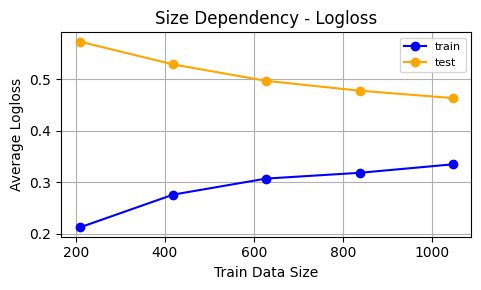

In [100]:
## Logloss

# プロット用データ
#x1 = list(res_train_logloss_average.keys())
x1 = list(train_size_average.values())
y1 = list(res_train_logloss_average.values())

#x2 = list(res_test_logloss_average.keys())
x2 = list(train_size_average.values())
y2 = list(res_test_logloss_average.values())

# グラフの作成
plt.figure(figsize=(5, 3))
plt.plot(x1, y1, marker='o', label='train', color='blue')
plt.plot(x2, y2, marker='o', label='test', color='orange')
plt.title('Size Dependency - Logloss', fontsize=12)
plt.xlabel('Train Data Size', fontsize=10)
plt.ylabel('Average Logloss', fontsize=10)
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()

# グラフを表示
plt.show()

In [93]:
res_train_logloss_average

{0.2: 0.21236492400127338,
 0.4: 0.2761785739939147,
 0.6: 0.30734120301715007,
 0.8: 0.3185784863470104,
 1: 0.33502339482311244}

In [94]:
res_test_logloss_average

{0.2: 0.5736346222490212,
 0.4: 0.5292297398459137,
 0.6: 0.49737966639728093,
 0.8: 0.4782198418407917,
 1: 0.46390261010171024}

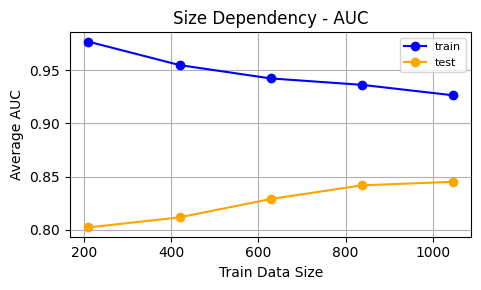

In [95]:
## AUC

# プロット用データ
#x1 = list(res_train_auc_average.keys())
x1 = list(train_size_average.values())
y1 = list(res_train_auc_average.values())

#x2 = list(res_test_auc_average.keys())
x2 = list(train_size_average.values())
y2 = list(res_test_auc_average.values())

# グラフの作成
plt.figure(figsize=(5, 3))
plt.plot(x1, y1, marker='o', label='train', color='blue')
plt.plot(x2, y2, marker='o', label='test', color='orange')
plt.title('Size Dependency - AUC', fontsize=12)
plt.xlabel('Train Data Size', fontsize=10)
plt.ylabel('Average AUC', fontsize=10)
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()

# グラフを表示
plt.show()

In [96]:
res_train_auc_average

{0.2: 0.9769165987946209,
 0.4: 0.9548427276567544,
 0.6: 0.9423324491074319,
 0.8: 0.9362736405123371,
 1: 0.9264663833075735}

In [97]:
res_test_auc_average

{0.2: 0.8022160493827161,
 0.4: 0.8117098765432098,
 0.6: 0.8289444444444445,
 0.8: 0.8417901234567902,
 1: 0.8451234567901235}